# Google Trends

In [ ]:
#Setup and Import Required Libraries
from pytrends.request import TrendReq


pytrends = TrendReq(hl='en-US', tz=360, retries=5, backoff_factor=0.1 ) 

In [31]:
# build payload

keyword = "Cabernet" # list of keywords to get data 
year = 2011
timeframe = f'{year}-01-01 {year}-12-31' # time frame for data
pytrends.build_payload([keyword], cat=0, timeframe=timeframe) # build payload

In [32]:
data = pytrends.interest_over_time() 
data = data.reset_index() 



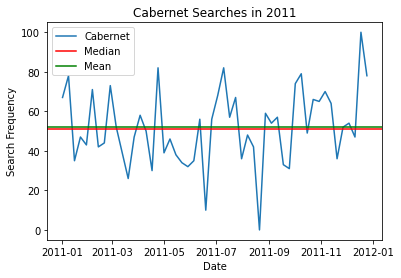

In [34]:
# plot the data 
import matplotlib.pyplot as plt
plt.plot(data['date'], data[keyword])
# add a median and average line
plt.axhline(y=data[keyword].median(), color='r', linestyle='-')
plt.axhline(y=data[keyword].mean(), color='g', linestyle='-')
# add a title and axis labels and legend
plt.title(f'{keyword} Searches in {year}')
plt.xlabel('Date')
plt.ylabel('Search Frequency')
plt.legend([keyword, 'Median', 'Mean'], loc='upper left')


In [76]:
#Setup and Import Required Libraries
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360, retries=5, backoff_factor=0.1 ) 
import statistics

# lets build a function to get the data for a list of keywords
def get_trend_data(keyword, year):
    timeframe = f'{year}-01-01 {year}-12-31'
    pytrends.build_payload([keyword], cat=0, timeframe=timeframe)
    data = pytrends.interest_over_time()
    return data.loc[:, keyword].tolist()

def get_aggregates(data):
    return statistics.median(data), statistics.mean(data)


In [81]:

m, n = get_aggregates(get_trend_data("Cabernet", 2011))

# Wine Quality

In [88]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import pyarrow

In [94]:
wine_quality = fetch_ucirepo(id=186) 
df = pd.DataFrame(wine_quality.data.original)

# save data to parquet
df.to_parquet('wine_quality.parquet')

# Harvest data

In [6]:
import faostat
import pandas as pd 

## offline

In [15]:
#Offline:
#faostat.list_pars('QCL')
#grapes = faostat.get_data_df('QCL', pars={'item':'560'}, show_flags=True, null_values=True)
#wine = faostat.get_data_df('QCL', pars={'item':'564'}, show_flags=True, null_values=True)
# save data to parquet
#grapes.to_parquet('grapes.parquet')
#wine.to_parquet('wine.parquet')


In [ ]:
# load data from parquet
import pandas as pd
import pyarrow
grapes = pd.read_parquet('grapes.parquet')
wine = pd.read_parquet('wine.parquet')


In [41]:
# get the data from the df grapes for the year 2011 and the area Argentina
#make this a def function
def get_data(df, year, area):
    return df.loc[(df['Year'] == str(year)) & (df['Area'] == area)]

# make def to get data of Column "Value" for Element = "Area harvested"
def get_value(df, element):
    return float(df.loc[df['Element'] == element]['Value'])

# make def to get three values for a country and year
def get_three_values(grapes, wine, country, year):
    df1 = get_data(grapes, year, country)
    df2 = get_data(wine, year, country)
    return get_value(df1, 'Area harvested'), get_value(df1, 'Production'), get_value(df2, 'Production')

# get three values for a country and year
get_three_values(grapes, wine, 'Italy', '2019')



(697910.0, 7900120.0, 4985862.0)

## Online

In [35]:
#online:
# make a def to get data for a country and year
def get_country_data(country, year):
    name_dict = faostat.get_par('QCL', 'area')
    df1 = faostat.get_data_df('QCL', pars={'item':'560', 'area':name_dict[country], 'year':year}, show_flags=True, null_values=True)
    df2 = faostat.get_data_df('QCL', pars={'item':'564', 'area':name_dict[country], 'year':year}, show_flags=True, null_values=True)
    return df1,df2

d1,d2 = get_country_data('Italy', '2019')

Yield is the Production divided by the Area harvested, so we only need 2 out of 3 for the first dataframe
and we only need Production for Wine

In [38]:
# make def to get data of Column "Value" for Element = "Area harvested"
def get_value(df, element):
    return float(df.loc[df['Element'] == element]['Value'])

# make def to get three values for a country and year
def get_three_values(country, year):
    df1, df2 = get_country_data(country, year)
    return get_value(df1, 'Area harvested'), get_value(df1, 'Production'), get_value(df2, 'Production')

# get three values for a country and year
get_three_values('Italy', '2019')

(697910.0, 7900120.0, 4985862.0)

# Weather Data
meteostat vs open-meteo

In [1]:
import numpy as np 
from geopy.exc import GeocoderTimedOut 
from geopy.geocoders import Nominatim 

from datetime import datetime
from meteostat import  Daily, Stations


In [22]:
# function to find the coordinate of a given city  
def findGeocode(city): 
       
    # try and catch is used to overcome the exception thrown by geolocator 
    try:  
        geolocator = Nominatim(user_agent="your_app_name") 
          
        return geolocator.geocode(city, language='en') 
      
    except GeocoderTimedOut: 
          
        return findGeocode(city)     


In [26]:
# make def to return latitude and longitude for a city given a country (more reliable because sometimes the same city name exists in different countries)
def get_lat_long(city, country):
    if findGeocode(city) != None: 
        if findGeocode(city).raw["display_name"].split(", ")[-1] == country:
            return findGeocode(city).latitude, findGeocode(city).longitude
        #return findGeocode(city).latitude, findGeocode(city).longitude
    else:
        # open csv file and append the data city to clean it later
        with open('log.csv', 'a') as f:
            f.write(city + '\n')
        return np.nan, np.nan

In [27]:
# average a df per column based on a multiindex if its non empty
def average_df(df):
    if not df.empty:
        df = df.groupby(level=1).mean()
    return df

# make def to get data based on a city and year from the n nearest stations
def get_weather(city, country, year, n):
    start = datetime(year, 1, 1)
    end = datetime(year, 12, 31)
    lat, lon = get_lat_long(city,country)
    stations = Stations()
    stations = stations.nearby(lat, lon)
    station = stations.fetch(n)
    data = Daily(station, start, end)
    data = data.fetch()
    return average_df(data)

### Reduce to growth period

In [28]:
# get df for certain time frame based on index
def get_growth_period(df, start, end):
    return df.loc[start:end]
#Growth period: may 11th - september 20th 
#https://en.wikipedia.org/wiki/Harvest_(wine)
#df = get_growth_period(df, '2019-03-11', '2019-09-20')

### get volatility

In [29]:
# get volatility of a single column
def get_volatility(df, column):
    return df[column].std()/df[column].mean()


### Longest drought

In [30]:
# get the longest consecutive sequence of a value in a df
def longest_sequence(df, column, value):
    return df[column].eq(value).astype(int).groupby(df[column].ne(value).cumsum()).sum().max()


### Longest rain period

In [31]:
# get the longest consecutive sequence of the absence (!) of a value in a df
# this is the longest sequence of days with rain
def longest_sequence_no(df, column, value):
    return df[column].ne(value).astype(int).groupby(df[column].eq(value).cumsum()).sum().max()

### Avg Rain

In [32]:
#Vines need between 400 and 600 mm of rain per year. 
#A regular supply of water throughout the growth cycle is needed for a high quality crop.
#https://www.idealwine.info/conditions-necessary-great-wine-part-12/
# get the avg of the column prcp for a df
def get_avg_prcp(df):
    return df['prcp'].mean()

### No of Days above 35 degrees 

In [33]:
#At temperatures below 10°C and above 35°C, photosynthesis will be disrupted and vines will not grow properly.
# count number of rows in a df column tmax above a threshold
def count_above(df, column, threshold):
    return df[df[column] > threshold][column].count()

### number of days below 10 degrees


In [34]:
# count number of rows in a df column tmax under a threshold

def count_under(df, column, threshold):
    return df[df[column] < threshold][column].count()

### coulure wspd

In [35]:
#strong wind around june --> coulure 
# get the avg of the column wspd for a df
def get_avg_wspd(df):
    df = get_growth_period(df, '2019-05-15', '2019-07-15')
    return df['wspd'].mean()

### May July Rain

In [36]:
#Too much rain during the May-July period --> diseases such as mildew or oidium
# sum the column prcp for a df
def get_sum_prcp(df):
    df = get_growth_period(df, '2019-05-15', '2019-07-15')
    return df['prcp'].sum()

## Combined Features
```
Temp Vola: get_volatility(df, 'tavg')
Rain Vola: get_volatility(df, 'prcp')
Longest drought: longest_sequence(df, 'prcp', 0)
Longest Rain: longest_sequence_no(df, 'prcp', 0) 
Avg Rain: get_avg_prcp(df)
NoDays35: count_above(df, 'tmax', 35)
NoDays10: count_under(df, 'tmin', 10)
NoDays0: count_under(df, 'tmin', 0)
ColourWspd: get_avg_wspd(df)
MayJulyRain: get_sum_prcp(df)
```

In [37]:
# combine all function in one function

def get_weather_features(city, country, year, n):
    raw = get_weather(city, country, year, n)
    df = get_growth_period(raw, '2019-03-11', '2019-09-20')
    return get_volatility(df, 'tavg'), get_volatility(df, 'prcp'), longest_sequence(df, 'prcp', 0), longest_sequence_no(df, 'prcp', 0), get_avg_prcp(df), count_above(df, 'tmax', 35), count_under(df, 'tmin', 10), count_under(df, 'tmin', 0), get_avg_wspd(df), get_sum_prcp(df)

#### Example:

In [40]:
Vola_Temp, Vola_Rain, Longest_Dry, Longest_Wet, Avg_Rain, Count_above35, Count_under10, Count_under0, Coulure_Wind, June_Rain = get_weather_features('Bordeaux','France', 2019, 5)
get_weather_features('Bordeaux','France', 2019, 5)

(0.2721517035543977,
 2.4652156924345996,
 16,
 7,
 1.7659793814432982,
 4,
 52,
 0,
 13.994758064516128,
 122.6)